<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 806, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 806 (delta 145), reused 114 (delta 63), pack-reused 591 (from 1)
Receiving objects: 100% (806/806), 3.96 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (527/527), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.methods import *
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
dataset_names = [
    "persona_based_prompt_s1_data",
    "chain_of_thought_simple_data",
    "zero_shot_simple_data",
    "one_shot_simple_data",
    "few_shot_simple_data",
]

In [7]:
raw_dfs = [load_df(dataset_name) for dataset_name in dataset_names]
ref_df = clean_sipgate_dataset(read_sipgate_dataset())

In [ ]:
framework = Framework()
evaluated_sets = []
for gen_df in raw_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets.append(df)

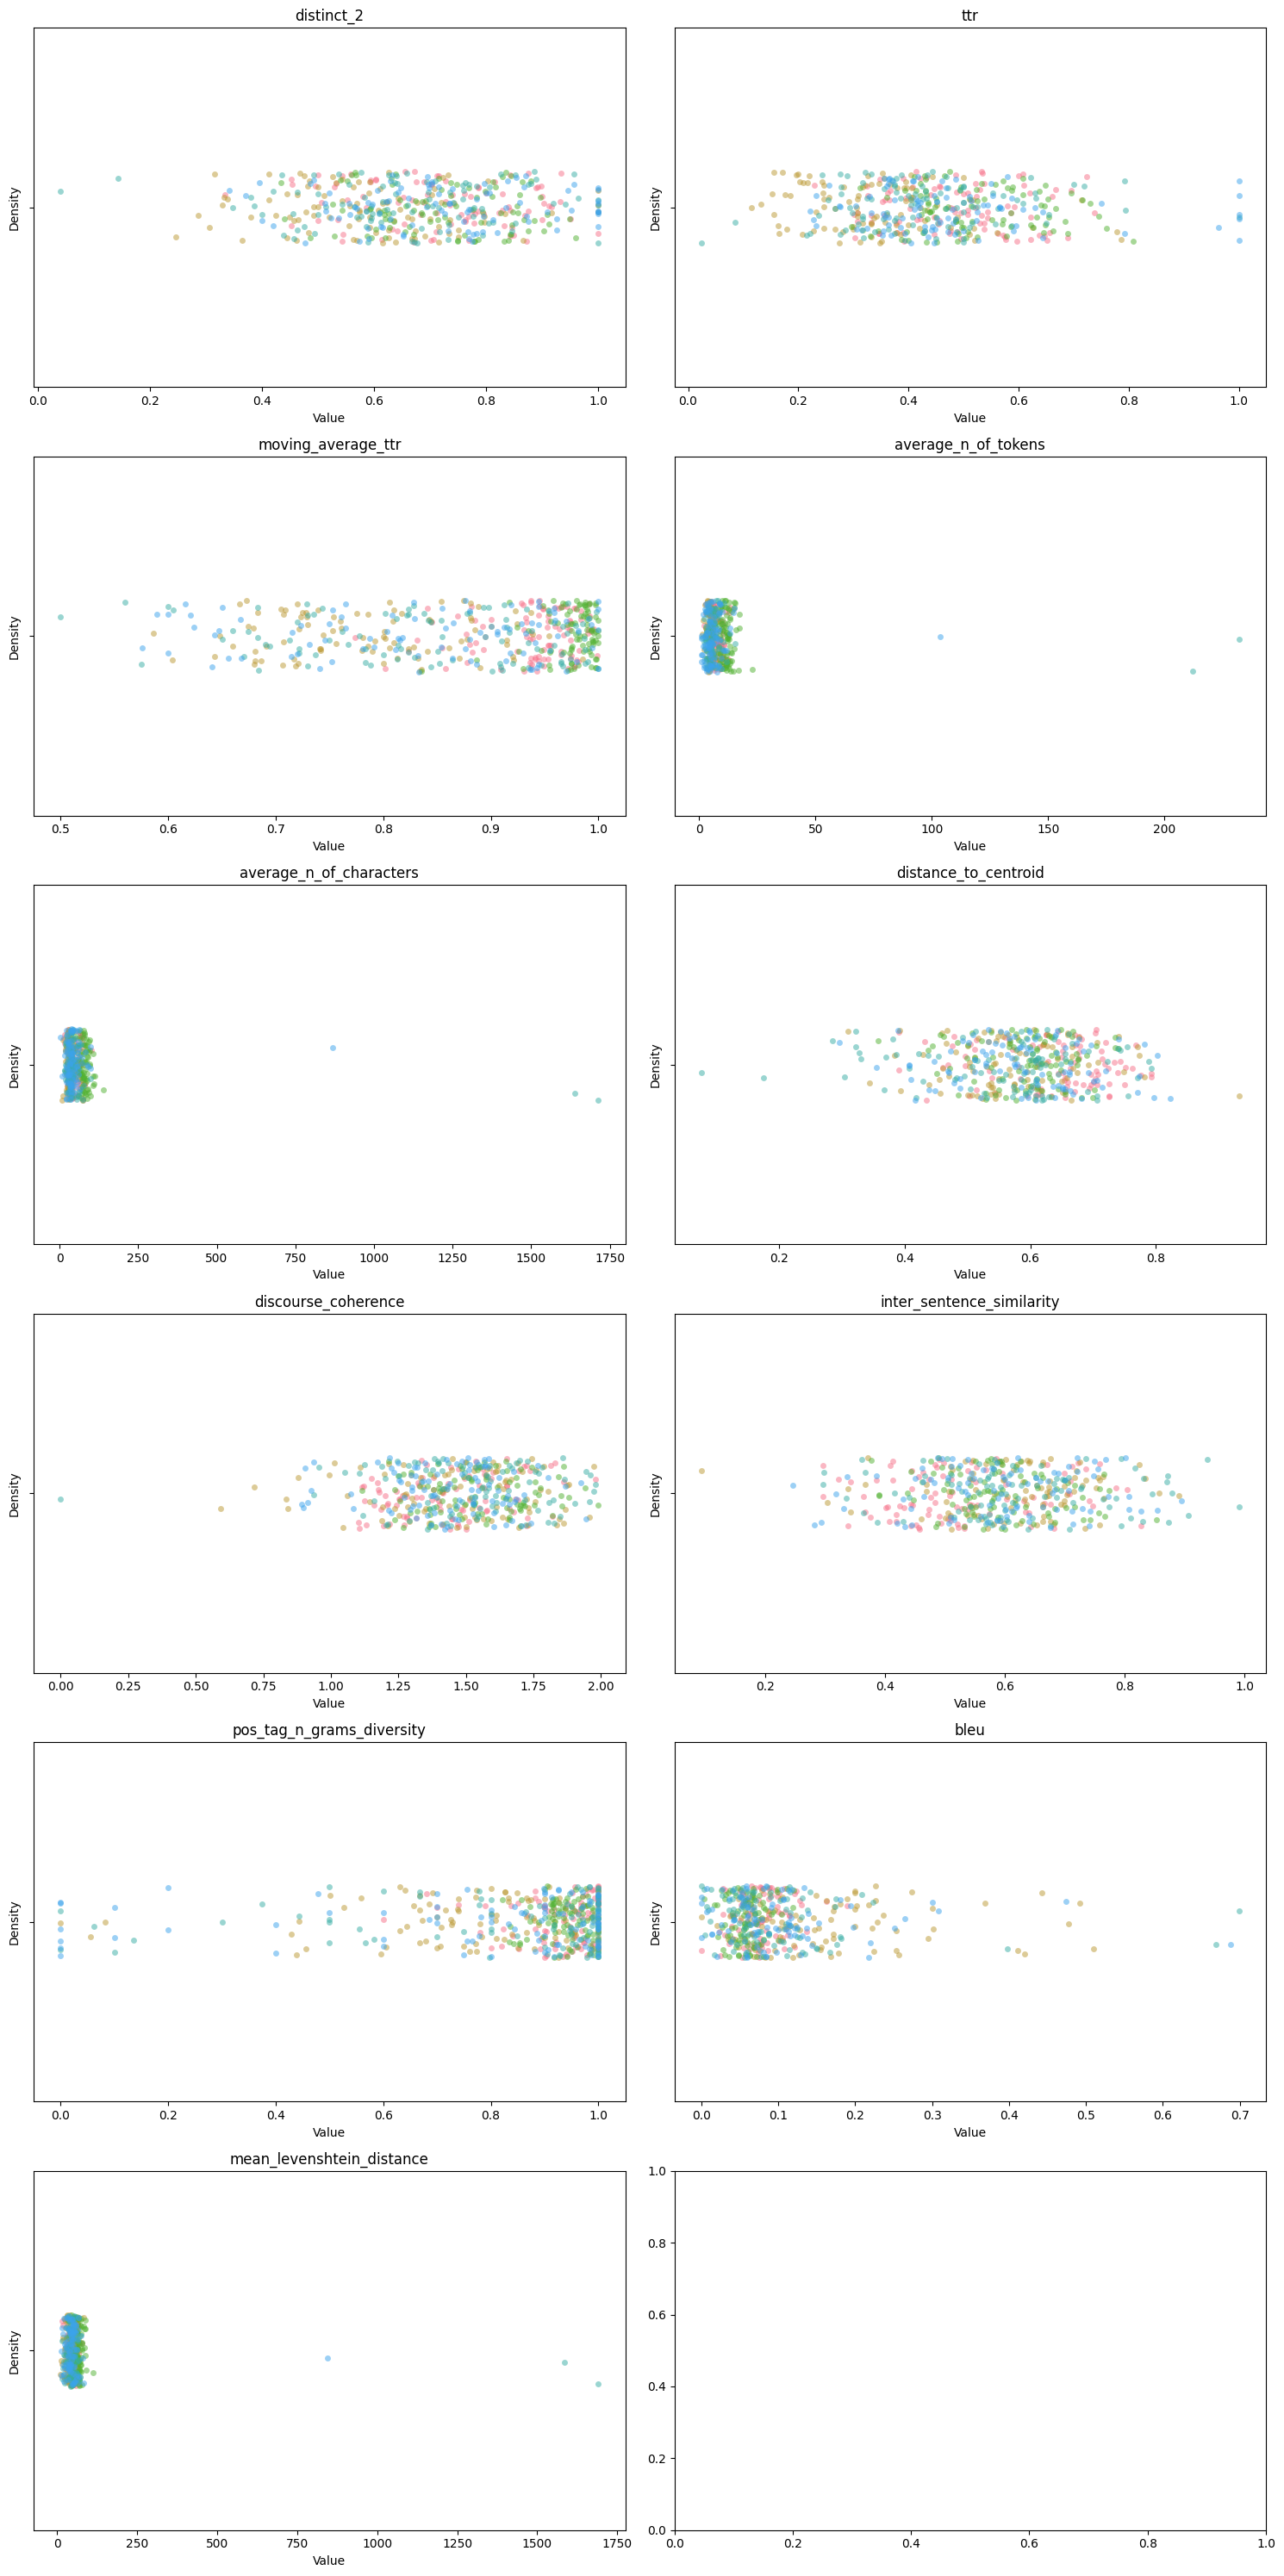

In [11]:
dfs_to_stripplots(evaluated_sets)

In [12]:
metric_dfs = transform_dfs_to_metric_dfs(evaluated_sets, dataset_names)
metric_names = list(framework.metrics)

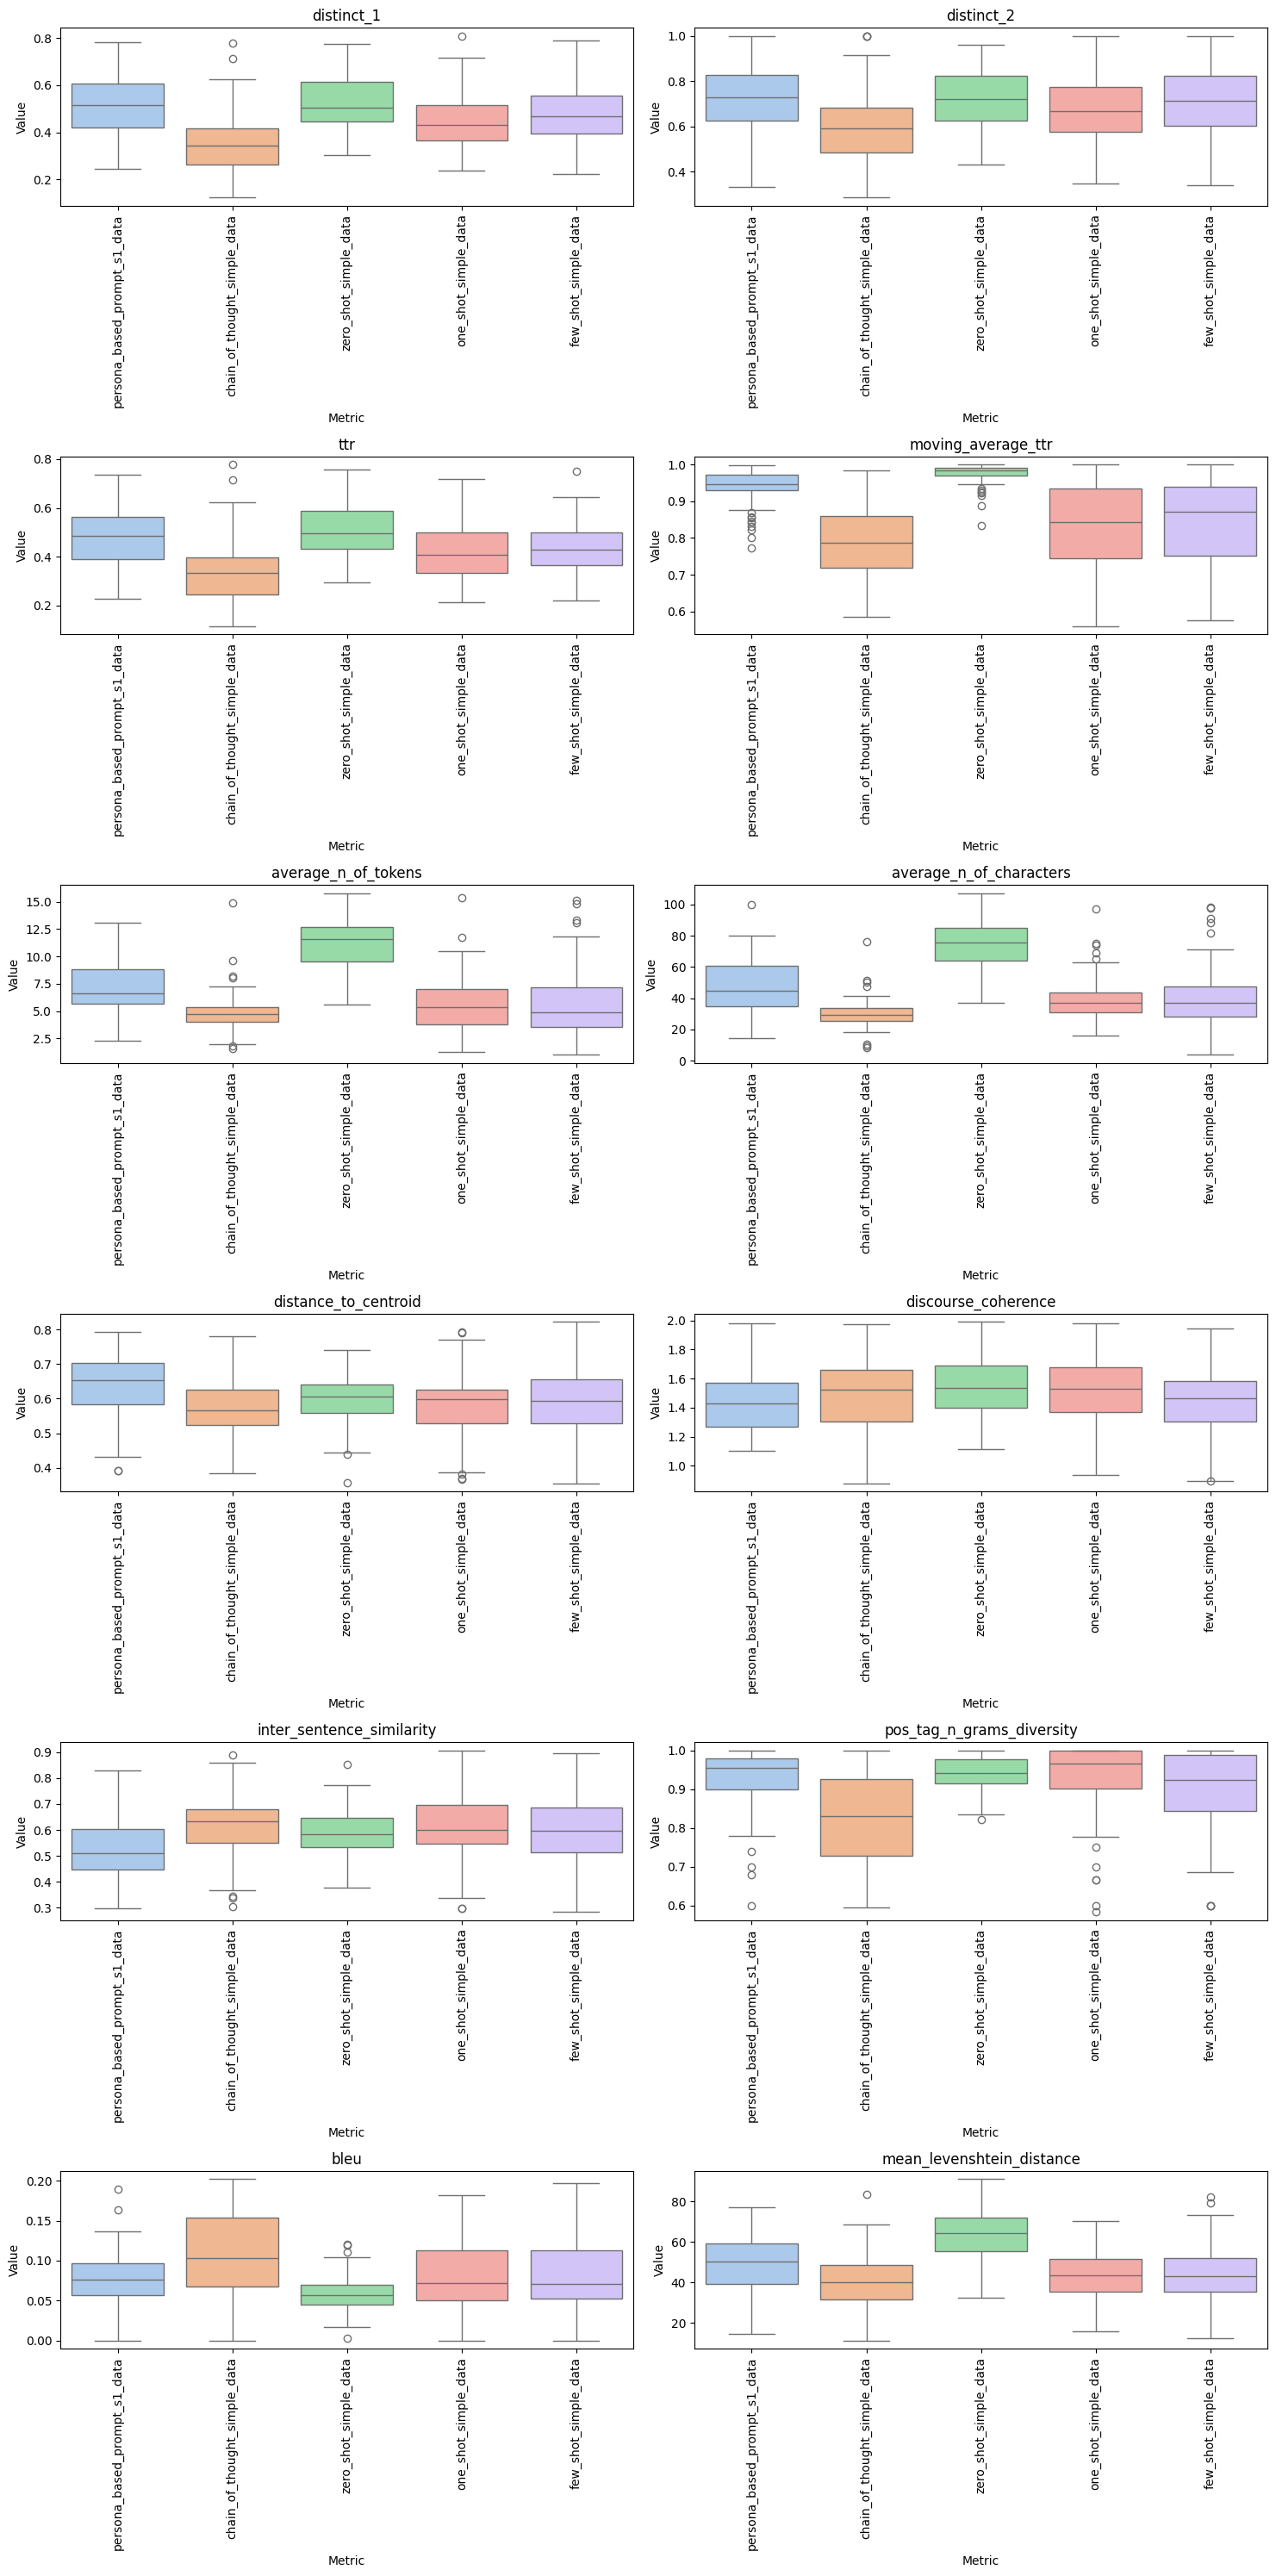

In [13]:
catplot_metric_dfs(metric_dfs, metric_names)

In [ ]:
dfs = [
    framework.apply_framework_to_datasets(load_df(dataset_name))
    for dataset_name in dataset_names
]
dfs.append(framework.apply_framework_to_datasets(ref_df))

In [15]:
result_dfs = [results_to_dataframe(df) for df in dfs]
transformed_dfs = transform_dfs_to_metric_dfs(
    result_dfs,
    columns= ["intent"] + dataset_names + ["sipgate"],
    dataset_names=dataset_names)
metric_names = list(framework.hypotheses_metrics)

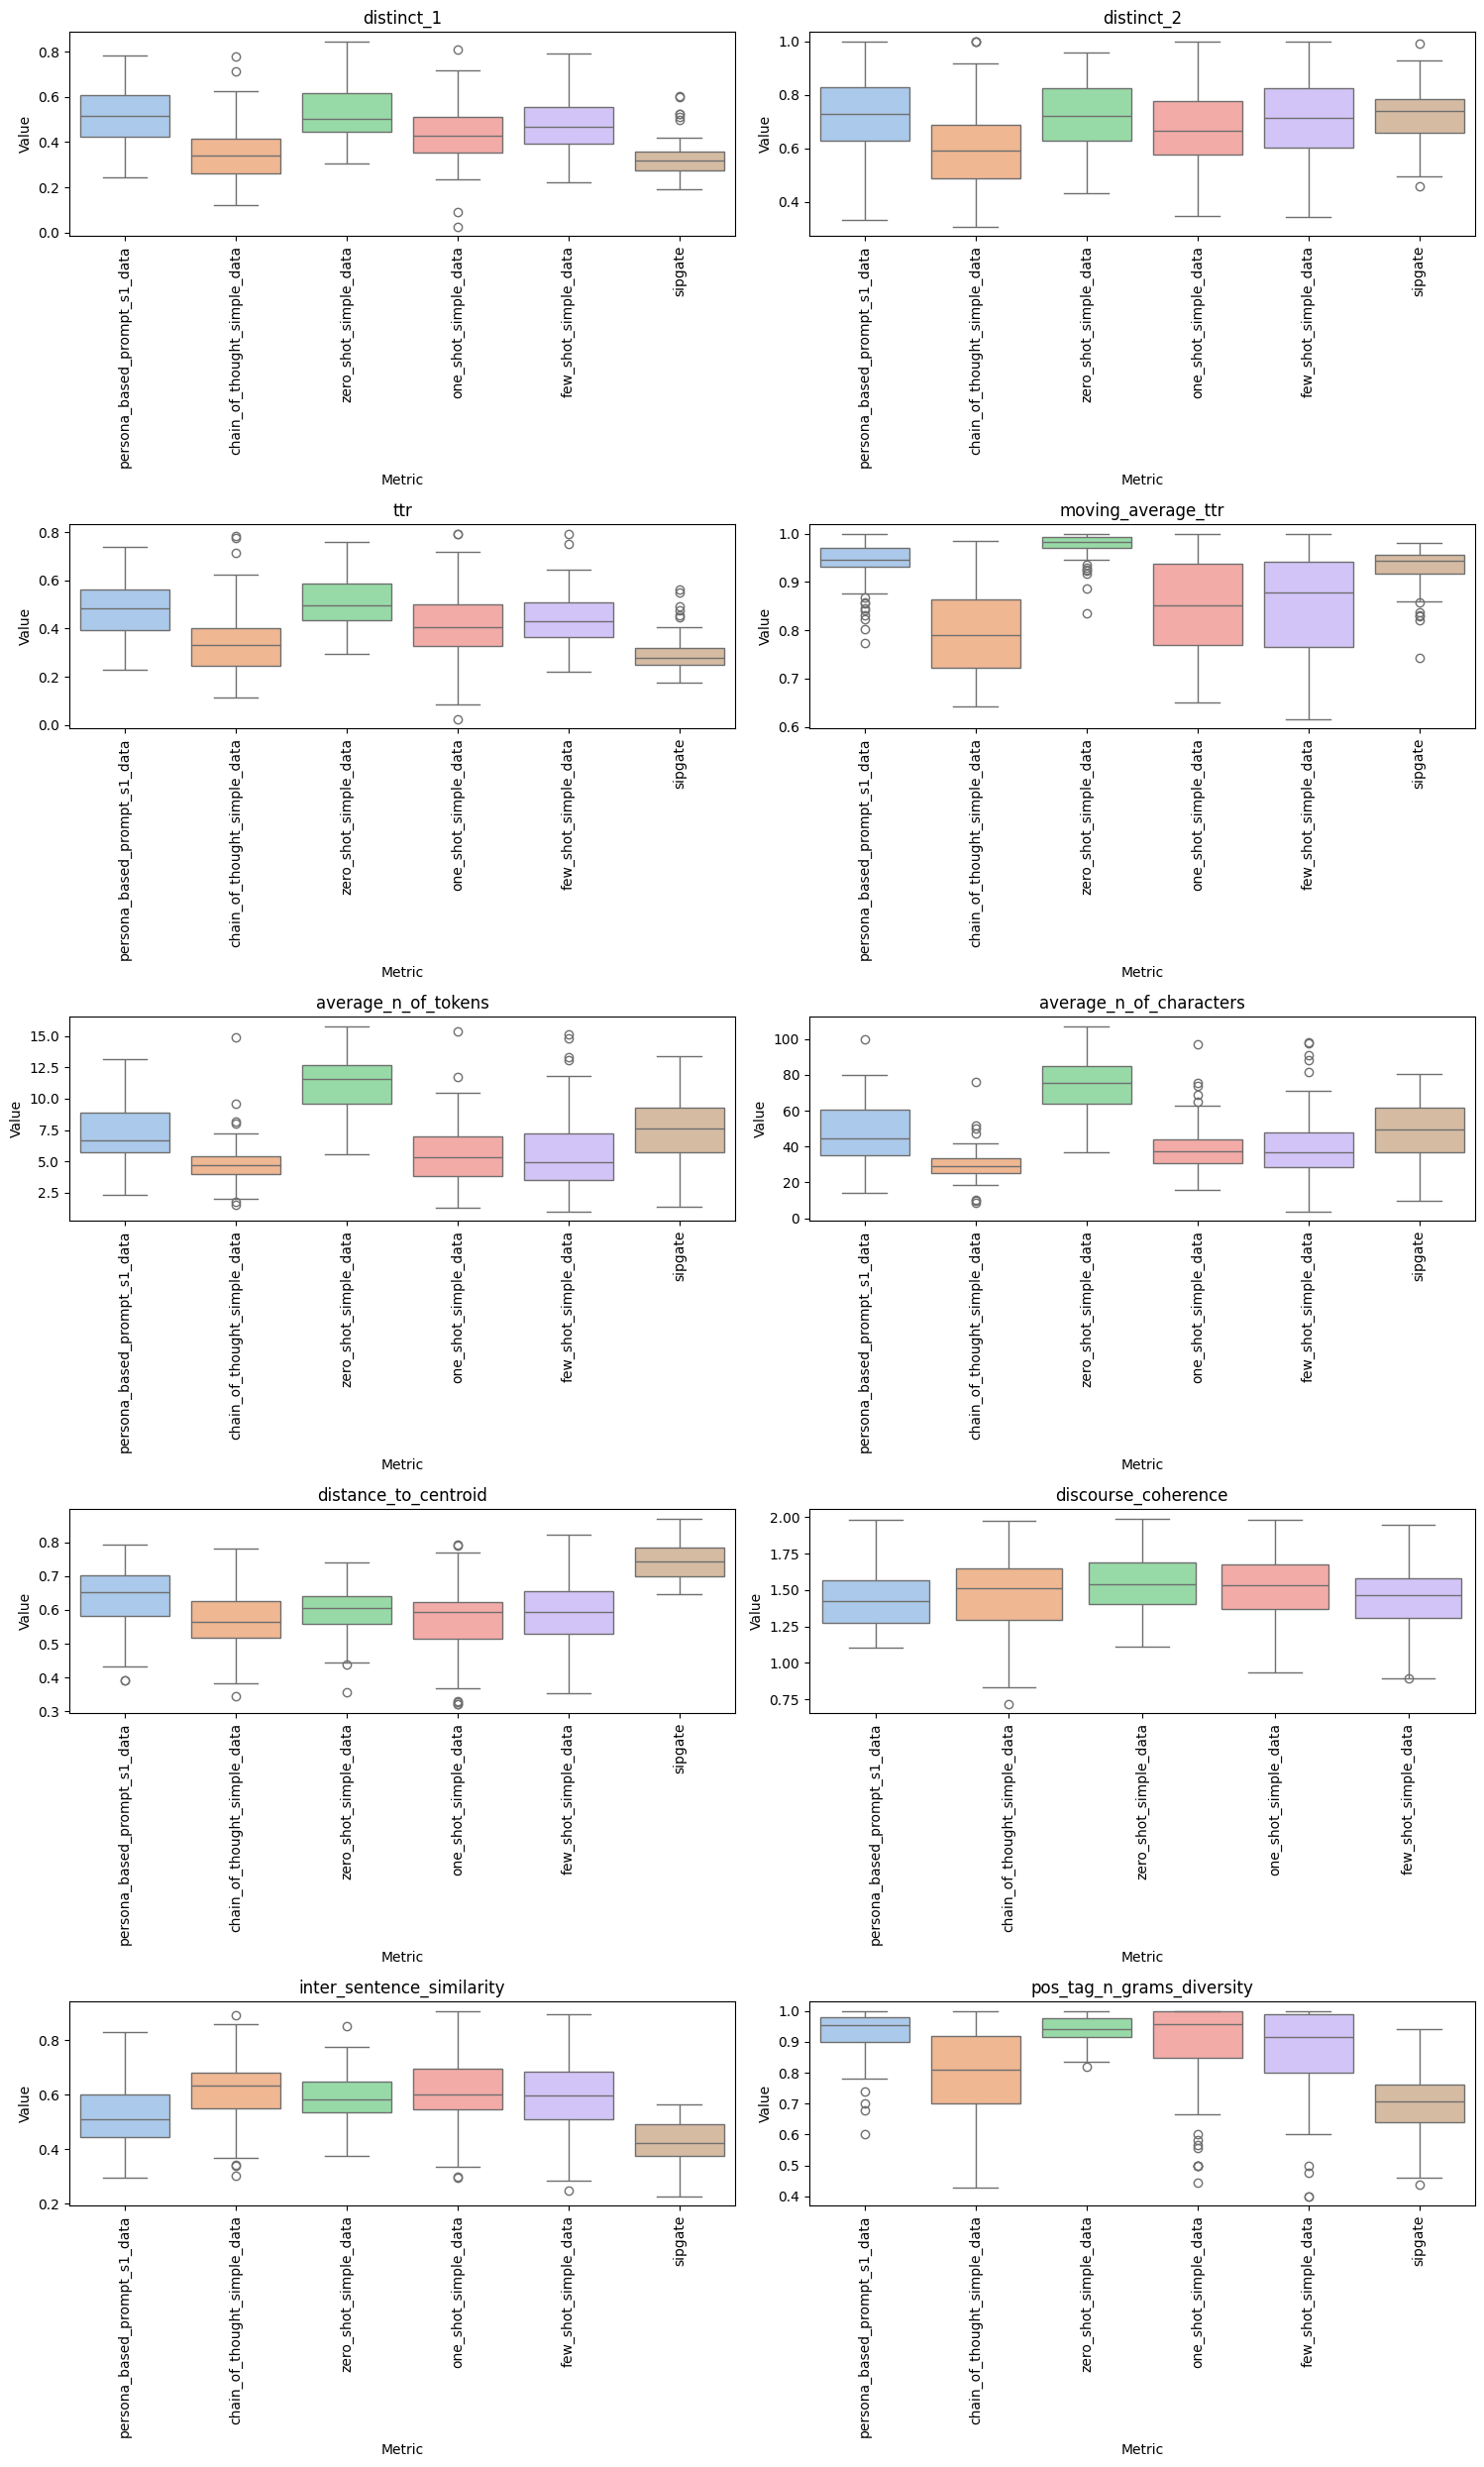

In [16]:
catplot_metric_dfs(transformed_dfs, framework.hypotheses_metrics)

In [20]:
from scipy.spatial.distance import jensenshannon
def js_divergence(p, q):
  p = np.asarray(p)
  q = np.asarray(q)
  return jensenshannon(p, q)

In [38]:
divergences = {}
for i, metric in enumerate(transformed_dfs):
    metric_name = metric_names[i].name
    divergences[metric_name] = {}
    golden_dist = metric.sipgate.tolist()
    for source in metric.columns[:-2]:
      dist = metric[source].tolist()
      divergence = js_divergence(golden_dist, dist)
      divergences[metric_name][source] = divergence

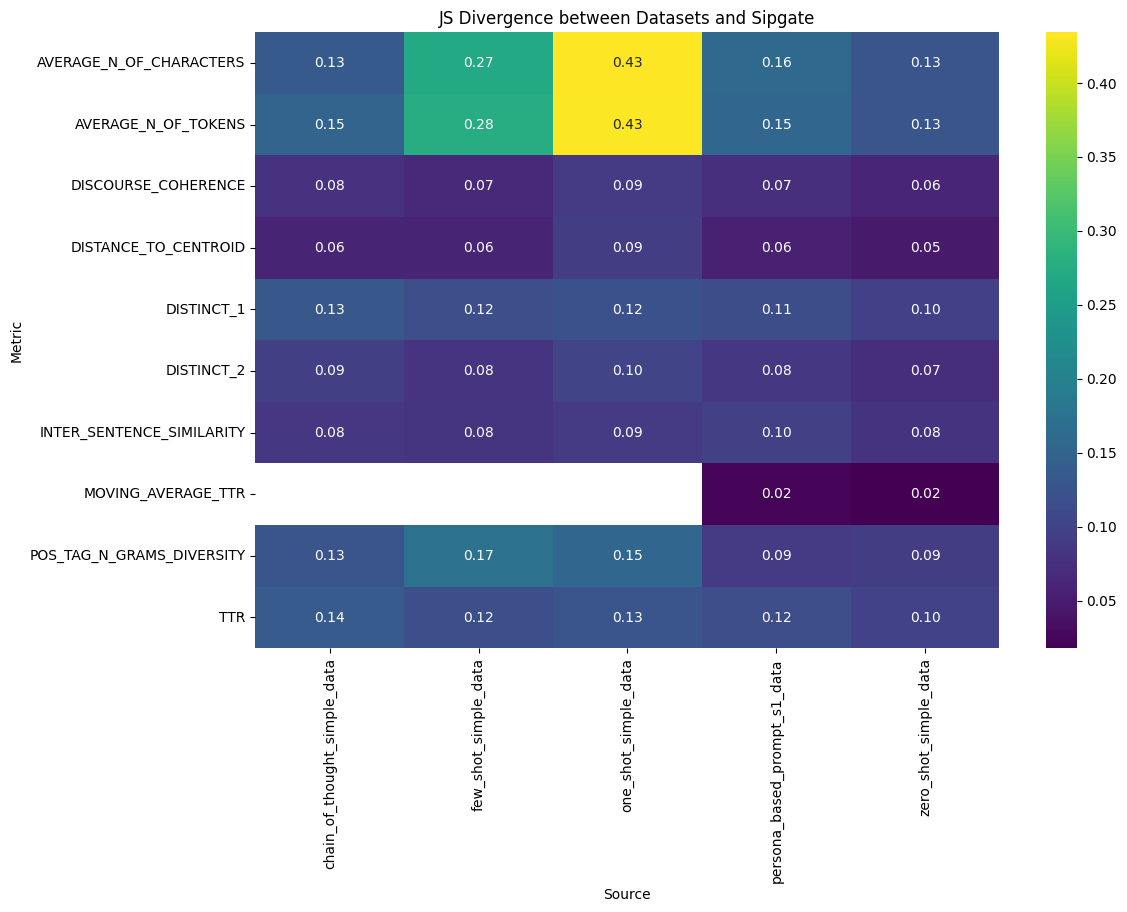

In [39]:
# prompt: generate a heatmap with the dataset sources on one axis and the metrics on the other axis

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'divergences' is a dictionary as defined in your previous code
# Create a DataFrame from the divergences dictionary
divergence_df = pd.DataFrame(divergences).T.reset_index()
divergence_df = pd.melt(divergence_df, id_vars=['index'], var_name='Source', value_name='JS Divergence')
divergence_df = divergence_df.rename(columns={'index': 'Metric'})

# Create the heatmap
plt.figure(figsize=(12, 8))
# The pivot function was called incorrectly, it should be called like this:
sns.heatmap(divergence_df.pivot(index='Metric', columns='Source', values='JS Divergence'), annot=True, cmap='viridis', fmt=".2f")
plt.title('JS Divergence between Datasets and Sipgate')
plt.show()